# **Text Classifier with the Twitter Dataset**

This notebook showcases the implementation of a text classification model using LSTM networks for sentiment analysis. Its purpose is to distinguish between positive and negative tweets from the [NLTK Twitter dataset](http://www.nltk.org/howto/twitter.html), an open-source Python library for natural language processing that features modules for collecting, handling, and processing Twitter data. However, in this model, TensorFlow is solely utilized for preprocessing, adding an additional challenge. Additionally, it includes visualization of word embeddings generated post-training.

### **Imports**

In [1]:
import tensorflow as tf
import nltk
from nltk.corpus import twitter_samples
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.core.display import HTML
from google.colab import drive
import imageio.v2 as imageio
import os

### **Parameters**

In [2]:
epochs = 5
batch_size = 64
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
vocab_size = 10000 #Including padding and unknown tokens
embedding_dim = 128

### **Load and Preprocess the Dataset**

In [3]:
nltk.download("twitter_samples")
positive_tweets = twitter_samples.strings("positive_tweets.json")
negative_tweets = twitter_samples.strings("negative_tweets.json")

# The dataset is balanced
len(positive_tweets), len(negative_tweets)

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


(5000, 5000)

**Split the tweets into training and testing sets**

In [4]:
df = pd.DataFrame({"tweet": np.array(positive_tweets + negative_tweets),
                   "label": np.concatenate([np.ones(len(positive_tweets)), np.zeros(len(negative_tweets))])})
df

,tweet,label
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1.0
1,@Lamb2ja Hey James! How odd :/ Please call our...,1.0
2,@DespiteOfficial we had a listen last night :)...,1.0
3,@97sides CONGRATS :),1.0
4,yeaaaah yippppy!!! my accnt verified rqst has...,1.0
...,...,...
9995,I wanna change my avi but uSanele :(,0.0
9996,MY PUPPY BROKE HER FOOT :(,0.0
9997,where's all the jaebum baby pictures :((,0.0
9998,But but Mr Ahmad Maslan cooks too :( https://t...,0.0


In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123, stratify=df["label"])

In [6]:
# Thanks to the 'stratify' argument, the distribution is preserved

print(len(df_train), len(df_test), "\n")
print((df_train.label.value_counts()/df_train.shape[0]) * 100, "\n")
print((df_test.label.value_counts()/df_test.shape[0]) * 100)

8000 2000 

label
1.0    50.0
0.0    50.0
Name: count, dtype: float64 

label
0.0    50.0
1.0    50.0
Name: count, dtype: float64


In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((df_train.tweet.values, df_train.label.values))
test_dataset = tf.data.Dataset.from_tensor_slices((df_test.tweet.values, df_test.label.values))

train_dataset = train_dataset.shuffle(buffer_size, seed=123).batch(batch_size).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

In [8]:
for tweets, labels in train_dataset.take(1):
  print(tweets[:10], "\n")
  print(labels[:10])

tf.Tensor(
[b'@ArunbuddyAP yes bro..lost many too :(' b'Always :)\nBe positive!'
 b'The best photobomb :D [pic] \xe2\x80\x94 https://t.co/3dP40WD5n2'
 b'@OLX_OHayoung96 sore ya :)'
 b'@Jamelyyyyy  follow @jnlazts &amp; http://t.co/RCvcYYO0Iq follow u back :)'
 b'If you are looking to find out more about @VirtualUmbrella give me a shout, sending out lots of emails today :) #fridayfun'
 b"@robinpatrickm why won't he talk to me :("
 b'@hamzaabasiali exactly but unfortunately :('
 b'BUT I HAVE IT ALREADY HE SOLD IT LIKE 2 WEEKS AGO :( https://t.co/FtgBvFN30O'
 b"Planning to send my email to chippy's vessel on Monday with PS : Happy Anniversary haha :))"], shape=(10,), dtype=string) 

tf.Tensor([0. 1. 1. 1. 1. 1. 0. 0. 0. 1.], shape=(10,), dtype=float64)


**Text Encoder Creation**

Text processing utilizes the ``TextVectorization`` layer, which encodes text into indices by frequency order (following the padding token and the unknown token), considering up to ``vocab_size``. Index tensors are padded with zeros up to the longest sequence in the batch (unless you set a fixed value for ``output_sequence_length``).

In [ ]:
# Create a custom standardization function

@tf.keras.saving.register_keras_serializable()
def preprocessing(tweet):
  # Convert all text to lowercase
  tweet = tf.strings.lower(tweet)

  # Remove stock market tickers like $GE
  tweet = tf.strings.regex_replace(tweet, r"\$\w*", "")
  # Remove hyperlinks
  tweet = tf.strings.regex_replace(tweet, r"https?://[^\s\n\r]+", "")
  # Remove Twitter usernames and email addresses
  tweet = tf.strings.regex_replace(tweet, r"(?:@[\w_]+)", "")
  tweet = tf.strings.regex_replace(tweet, r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "")
  # Remove phone numbers and cell numbers
  tweet = tf.strings.regex_replace(tweet, r"(\+\d{1,3}[-\s]?)?\d{1,3}[-\s]?\d{1,2}[-\s]?\d{2,4}[-\s]?\d{3,4}", "")
  # Replace the apostrophe with an empty string
  tweet = tf.strings.regex_replace(tweet, r"\b(\w+)'(\w+)\b", r"\1\2")
  # Remove HTML entities
  tweet = tf.strings.regex_replace(tweet, r"&(#?(x?))([^&;\s]+);", "")

  # Remove all punctuation, keeping the emoticons
  emoticons = r"(?:[<>]?[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]|[\)\]\(\[dDpP/\:\}\{@\|\\][\-o\*\']?[:;=8][<>]?|</?3)"
  punctuation = r'[!"#$%&()\*\+,\-\.\/:;<=>?@\[\\\]^_`{|}~\']'
  tweet = tf.strings.regex_replace(tweet, r"(" + emoticons + r")|" + punctuation, r"\1 ")

  # Replace sequences of repeated characters of length 3 or greater with sequences of length 3
  # tf.strings.regex_replace(tweet, r"(.)\1{2,}", r"\1\1\1") generates an ERROR because it does not support backreferences
  alphabet = tf.strings.unicode_split("abcdefghijklmnopqrstuvwxyz", input_encoding="UTF-8")
  idx = tf.constant(0)

  tweet = tf.while_loop(
      cond=lambda i, _: tf.less(i, tf.size(alphabet)),
      body=lambda i, t: (
          tf.add(i, 1),
          tf.strings.regex_replace(
              t,
              tf.strings.join([alphabet[i], "{3,}"], separator=""),
              tf.strings.join([alphabet[i]]*3, separator="")
          )
      ),
      loop_vars=[idx, tweet]
  )[1]

  # Remove all redundant white spaces
  tweet = tf.strings.regex_replace(tf.strings.strip(tweet), "\s+", " ")

  return tweet

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=vocab_size,
                                            standardize=preprocessing
                                            )
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())

In [ ]:
print(encoder.vocabulary_size())
vocab[:10]

10000


array(['', '[UNK]', ':(', ':)', 'i', 'to', 'you', 'the', 'a', 'and'],
      dtype='<U42')

In [ ]:
encoded_tweets = encoder(tweets).numpy()
print(encoded_tweets.shape)
encoded_tweets

(64, 26)


array([[ 127,  445,  439, ...,    0,    0,    0],
       [ 125,    3,   26, ...,    0,    0,    0],
       [   7,  162, 6446, ...,    0,    0,    0],
       ...,
       [   4,   50,   18, ...,    0,    0,    0],
       [  16, 6827, 4381, ...,    0,    0,    0],
       [ 347, 2827, 3899, ...,    0,    0,    0]])

In [ ]:
# Visualizing tweet processing

np.random.seed(4) #For reproducibility
indices = np.arange(len(tweets))
np.random.shuffle(indices)

for i in range(10):
  print("Raw Tweet:", tweets[indices[i]].numpy().decode("utf-8"))
  print("Processed Tweet:", " ".join(vocab[encoded_tweets[indices[i]]]), "\n")

Raw Tweet: @TitusOReily dammit I tipped Carlton :( #AFLBluesHawks
Processed Tweet: dammit i tipped carlton :( aflblueshawks                     

Raw Tweet: @Jamelyyyyy  follow @jnlazts &amp; http://t.co/RCvcYYO0Iq follow u back :)
Processed Tweet: follow follow u back :)                      

Raw Tweet: @shounshounette @yassmin_a so kind :)
Processed Tweet: so kind :)                        

Raw Tweet: @misshollylou Hey, here's your invite to join Scope as an influencer :)  http://t.co/ipJ2yOiGet
Processed Tweet: hey heres your invite to join scope as an influencer :)                

Raw Tweet: @leomanaids_ look here u little shit :-) I fell asleep &amp; then woke up &amp; thought u were asleep :-) PLUS this was earlier :-) so fuk u dude
Processed Tweet: look here u little shit :-) i fell asleep then woke up thought u were asleep :-) plus this was earlier :-) so fuk u dude 

Raw Tweet: YEYY finally but my HD brows kit is broken slightly :(( @cohorted http://t.co/5CNhhfJpnJ
Processe

### **Build the Model**

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
tf.random.set_seed(123) #For reproducibility

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=encoder.vocabulary_size(),
                              output_dim=embedding_dim,
                              mask_zero=True, #To handle variable sequence lengths
                              name="embedding"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirection  (None, 64)                41216     
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1323329 (5.05 MB)
Trainable params: 132332

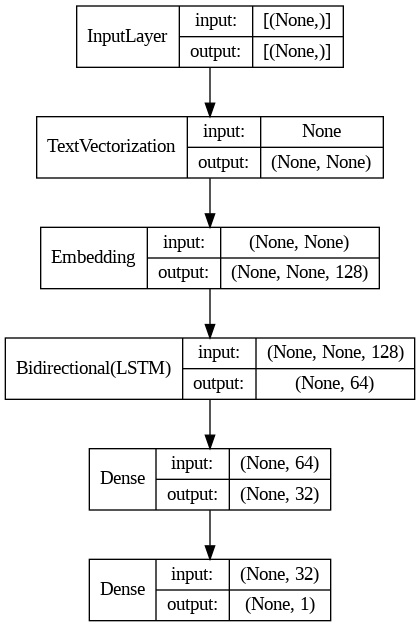

In [ ]:
# Visualizing the architecture of the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

### **Compile and Train the Model**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics="accuracy")

In [ ]:
tf.random.set_seed(123)
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/5
125/125 [==============================] - 23s 100ms/step - loss: 0.2124 - accuracy: 0.9507 - val_loss: 0.0220 - val_accuracy: 0.9945
Epoch 2/5
125/125 [==============================] - 6s 46ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0115 - val_accuracy: 0.9960
Epoch 3/5
125/125 [==============================] - 4s 31ms/step - loss: 7.3602e-04 - accuracy: 1.0000 - val_loss: 0.0112 - val_accuracy: 0.9960
Epoch 4/5
125/125 [==============================] - 3s 28ms/step - loss: 3.3813e-04 - accuracy: 1.0000 - val_loss: 0.0114 - val_accuracy: 0.9965
Epoch 5/5
125/125 [==============================] - 3s 24ms/step - loss: 2.0340e-04 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 0.9965


**Save model**

In [12]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
model.save("/content/drive/MyDrive/models/SentimentAnalysis_LSTM_Twitter.keras")

### **Dataset Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.0001521406084066257, 1.0]
[0.01152442954480648, 0.9965000152587891]


The training set achieves 100% accuracy in just 5 epochs, and the test set accuracy is 99.7%. This suggests that the model is extremely effective, as it shows neither overfitting nor underfitting. This accomplishment reflects outstanding work in tweet processing, model architecture design, and the efficient selection of its hyperparameters.

In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=epochs):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = metric.capitalize()

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

**Interactive graphics**

In [ ]:
plot_metrics()

In [ ]:
plot_metrics(metric="accuracy")

**Images for GitHub**

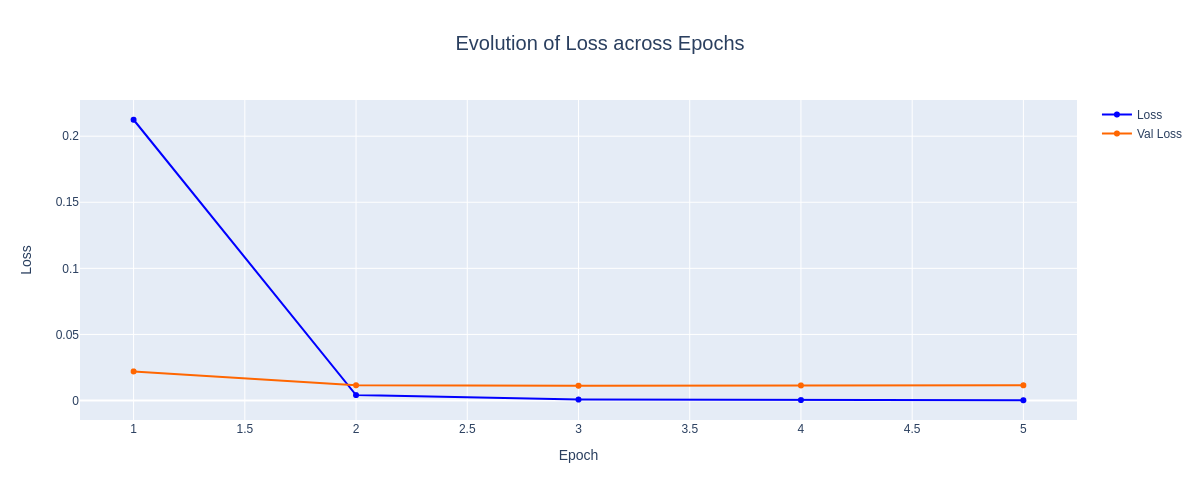

In [ ]:
plot_metrics(renderer="png")

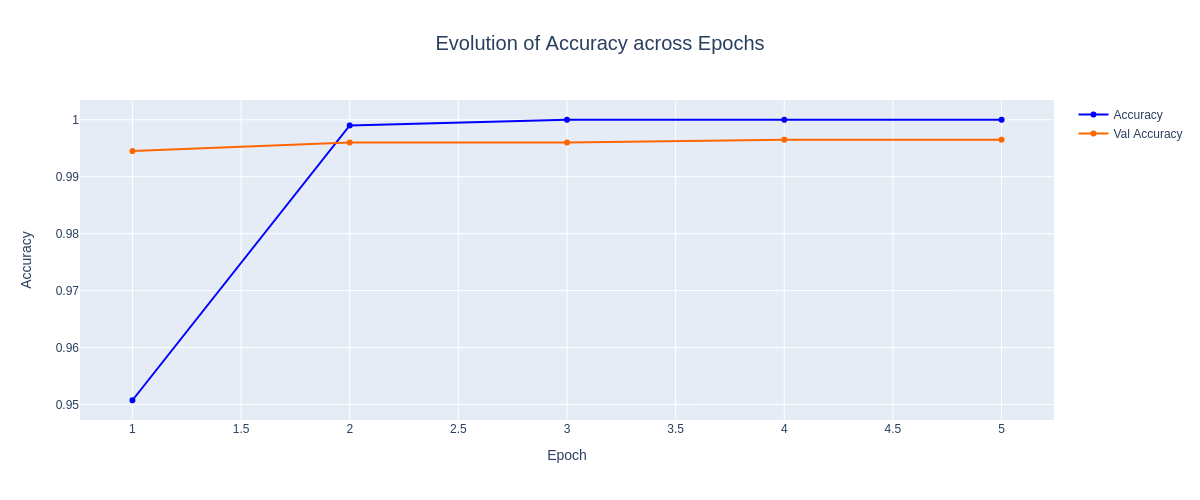

In [ ]:
plot_metrics(renderer="png", metric="accuracy")

**Confusion Matrix**

In [ ]:
labels_test = test_dataset.unbatch().map(lambda text, label: label)
labels_test = np.array(list(labels_test.as_numpy_iterator()), dtype=np.int32)

labels_test_pred = model.predict(test_dataset, verbose=0).squeeze()
labels_test_pred = (labels_test_pred>=0.5).astype(np.int32)

In [ ]:
# Consolidating the accuracy of the testing set
np.mean(labels_test == labels_test_pred)

0.9965

Total Negative:  1000 ; Total Positive:  1000


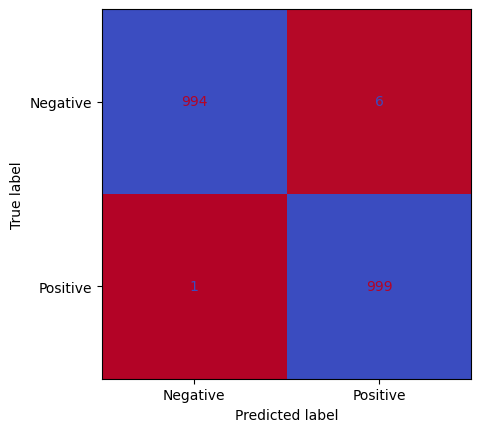

In [ ]:
cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
cmd.plot(colorbar=False, cmap="coolwarm_r");
print("Total Negative: ", np.bincount(labels_test)[0], "; Total Positive: ", np.bincount(labels_test)[1])

In [ ]:
(6/1000)*100, (1/1000)*100

(0.6, 0.1)

It is observed that the model has slightly more difficulty correctly classifying negative tweets compared to positive tweets in the test set. This is reflected in a higher percentage of false positives (0.6%) compared to false negatives (0.1%). However, as can be seen, the error is very low in both cases, indicating that our bidirectional LSTM network was highly effective.

### **Predictions with the trained model**

In [10]:
# Custom standardization function
@tf.keras.saving.register_keras_serializable()
def preprocessing(tweet):
  tweet = tf.strings.lower(tweet)

  tweet = tf.strings.regex_replace(tweet, r"\$\w*", "")
  tweet = tf.strings.regex_replace(tweet, r"https?://[^\s\n\r]+", "")
  tweet = tf.strings.regex_replace(tweet, r"(?:@[\w_]+)", "")
  tweet = tf.strings.regex_replace(tweet, r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "")
  tweet = tf.strings.regex_replace(tweet, r"(\+\d{1,3}[-\s]?)?\d{1,3}[-\s]?\d{1,2}[-\s]?\d{2,4}[-\s]?\d{3,4}", "")
  tweet = tf.strings.regex_replace(tweet, r"\b(\w+)'(\w+)\b", r"\1\2")
  tweet = tf.strings.regex_replace(tweet, r"&(#?(x?))([^&;\s]+);", "")

  emoticons = r"(?:[<>]?[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]|[\)\]\(\[dDpP/\:\}\{@\|\\][\-o\*\']?[:;=8][<>]?|</?3)"
  punctuation = r'[!"#$%&()\*\+,\-\.\/:;<=>?@\[\\\]^_`{|}~\']'
  tweet = tf.strings.regex_replace(tweet, r"(" + emoticons + r")|" + punctuation, r"\1 ")

  alphabet = tf.strings.unicode_split("abcdefghijklmnopqrstuvwxyz", input_encoding="UTF-8")
  idx = tf.constant(0)
  tweet = tf.while_loop(
      cond=lambda i, _: tf.less(i, tf.size(alphabet)),
      body=lambda i, t: (
          tf.add(i, 1),
          tf.strings.regex_replace(
              t,
              tf.strings.join([alphabet[i], "{3,}"], separator=""),
              tf.strings.join([alphabet[i]]*3, separator="")
          )
      ),
      loop_vars=[idx, tweet]
  )[1]

  tweet = tf.strings.regex_replace(tf.strings.strip(tweet), "\s+", " ")

  return tweet

In [13]:
# Load model
tf.keras.backend.clear_session()
model = tf.keras.models.load_model("/content/drive/MyDrive/models/SentimentAnalysis_LSTM_Twitter.keras")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirection  (None, 64)                41216     
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1323329 (5.05 MB)
Trainable params: 132332

In [22]:
def predict_tweet(texts, labels, random=True):
  label_names = ["Negative Tweet", "Positive Tweet"]
  label_colors = ["red", "green"]
  labels = tf.cast(labels, tf.int32)
  indice = np.random.choice(len(texts)) if random else 0
  labels_pred = model.predict(texts, verbose=0).squeeze(axis=-1)
  labels_pred = (labels_pred>=0.5).astype(np.int32)

  html_content = f"""
    <b>Tweet:</b><br><br>
    {texts[indice].numpy().decode("utf-8")}<br><br>
    <b>True Label: <span style="color: {label_colors[labels[indice]]}">{label_names[labels[indice]]}</span></b><br><br>
    <b>Predicted Label: <span style="color: {label_colors[labels_pred[indice]]}">{label_names[labels_pred[indice]]}</span></b>
    """
  display(HTML(html_content))

**Test Dataset**

In [16]:
texts, labels = next(iter(test_dataset))

In [23]:
predict_tweet(texts, labels, random=False)

In [35]:
predict_tweet(texts, labels)

In [39]:
predict_tweet(texts, labels)

In [ ]:
predict_tweet(texts, labels)

In [40]:
predict_tweet(texts, labels)

In [43]:
predict_tweet(texts, labels)

**Other Tweets**

In [44]:
text = "@user_tweet I'm happy because user_tweet@gmail.com I'm learning :) 😊"
text = tf.constant([text], tf.string)
label = tf.constant([1], tf.int32)

predict_tweet(text, label)

In [46]:
text = """
This service is a complete scam! 😡 They don't deliver on any of their promises,
they just want to steal your money. #Disappointment #Fraud https://fraud.com
"""
text = tf.constant([text], tf.string)
label = tf.constant([0], tf.int32)

predict_tweet(text, label)

In [56]:
# Most challenging tweet

text = """
@user_2024 What a mess of a day! Yet, amidst the chaos, I found moments of clarity
and strength. 💪✨ #FindingSilverLinings #GrowthMindset
"""
text = tf.constant([text], tf.string)
label = tf.constant([1], tf.int32)

predict_tweet(text, label)

In [62]:
# Most challenging tweet

text = """
Just had the most 'exciting' customer service experience ever
Can't believe how 'helpful' they were... NOT! #CustomerServiceFail #Disappointed
"""
text = tf.constant([text], tf.string)
label = tf.constant([0], tf.int32)

predict_tweet(text, label)

The model demonstrates accurate predictions not only within the test set but also with other tweets that do not belong to either the training or test sets. Furthermore, it showcases significant robustness by correctly classifying challenging tweets: those with a negative appearance that are actually positive, or vice versa.

### **Visualize Word Embeddings with Principal Component Analysis (PCA)**

In [63]:
# Obtaining the vocabulary from the encoder layer and the weights from the trained embedding layer

vocab = model.layers[0].get_vocabulary()
vocab = {word:i for i, word in enumerate(vocab)}

embedding = model.get_layer("embedding").get_weights()[0]
embedding.shape #(vocab_size, embedding_dim)

(10000, 128)

In [70]:
def compute_pca(X, n_components=2):
  pca = PCA(n_components=n_components, random_state=42)
  X_pca = pca.fit_transform(X)
  return X_pca

In [71]:
embedding_2d = compute_pca(embedding)
embedding_3d = compute_pca(embedding, n_components=3)

embedding_2d.shape, embedding_3d.shape

((10000, 2), (10000, 3))

In [132]:
# Some exemplary words
words = [
    "happy", "great", "awesome", "excited", "wonderful", "fantastic", "beautiful", ":)", ":-)", "🎉", "👍",
    "hate", "sad", "bad", "terrible", "disappointed", "awful", "horrible", ":(", ":-(", "😞", "😢",
]

colors = ["green"]*11 + ["red"]*11

In [125]:
words_2d = np.array([embedding_2d[vocab.get(word, 1)] for word in words]) #Index 1 corresponds to [UNK]
words_3d = np.array([embedding_3d[vocab.get(word, 1)] for word in words])

**With Plotly (interactive graph)**

In [126]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=words_2d[:11, 0], y=words_2d[:11, 1],
                         mode="markers+text", marker_color="green",
                         text=words[:11], textposition="top right",
                         marker_size=10, textfont_size=13,
                         name="positive"))

fig.add_trace(go.Scatter(x=words_2d[11:, 0], y=words_2d[11:, 1],
                         mode="markers+text", marker_color="red",
                         text=words[11:], textposition="top right",
                         marker_size=10, textfont_size=13,
                         name="negative"))

fig.update_layout(title="<b>2D Embeddings of NLTK Twitter Vocabulary</b>",
                  title_font=dict(size=18), title_x=0.5, height=800, width=1200,
                  xaxis_title="<b>$Z_1$</b>", yaxis_title="<b>$Z_2$</b>")

fig.show()

# Use the Box Select tool to better view

In the vector space, it's evident that the emoticons ``:)`` and ``:-)`` are starkly opposite to the emoticons ``:(`` and ``:-(``.

In [ ]:
!pip install tensorflow_docs -q

import tensorflow_docs.vis.embed as embed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 1.9 MB/s eta 0:00:00



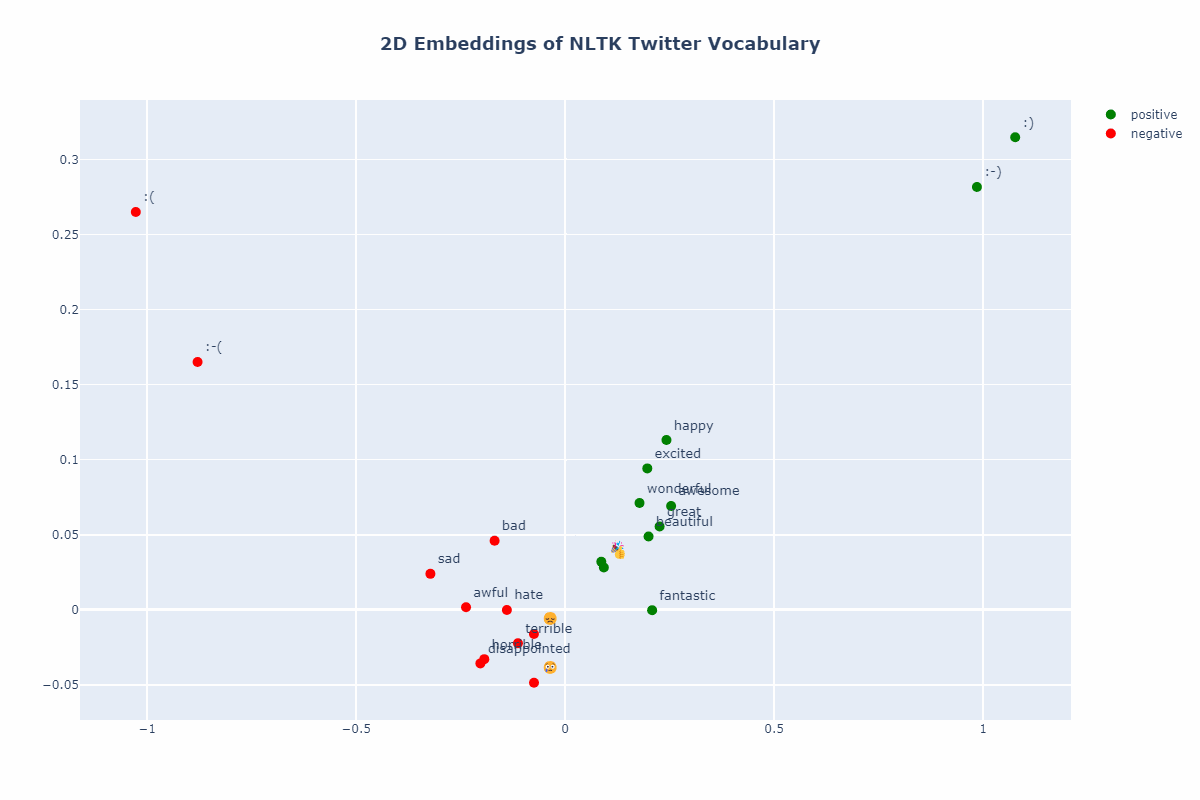

In [129]:
# GIF with images manually downloaded with the help of the graph generated by Plotly
images = ["image1.png", "image2.png"]
with imageio.get_writer("embedding_2d.gif", mode="I", loop=0, fps=0.5) as writer:
    for image in images:
      image = imageio.imread(image)
      writer.append_data(image)

embed.embed_file("embedding_2d.gif")

In [100]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(x=words_3d[:11, 0], y=words_3d[:11, 1], z=words_3d[:11, 2],
                           mode="markers+text", marker_color="green",
                           text=words[:11], textposition="top center",
                           marker_size=7, textfont_size=13,
                           name="not sarcastic"))

fig.add_trace(go.Scatter3d(x=words_3d[11:, 0], y=words_3d[11:, 1], z=words_3d[11:, 2],
                           mode="markers+text", marker_color="red",
                           text=words[11:], textposition="top center",
                           marker_size=7, textfont_size=13,
                           name="sarcastic"))

fig.update_layout(title="<b>3D Embeddings of NLTK Twitter Vocabulary</b>",
                  title_font=dict(size=18), title_x=0.5, height=800, width=1200,
                  scene=dict(xaxis_title="<b>Z_1</b>", yaxis_title="<b>Z_2</b>", zaxis_title="<b>Z_3</b>"))

fig.show()

In [101]:
# Function to create gifs

def create_gif(gif_file, fig, fps=1):

  images = []
  angles = np.arange(0, 361, 20)

  # Initial Image
  fig.write_image("temp.png")
  images.append(imageio.imread("temp.png"))
  os.remove("temp.png")

  for angle in angles:
    fig.update_layout(scene_camera=dict(
        eye=dict(x=np.sin(np.radians(angle)), y=np.cos(np.radians(angle)))
        )
    )
    fig.write_image("temp.png")
    images.append(imageio.imread("temp.png"))
    os.remove("temp.png")

  with imageio.get_writer(gif_file, mode="I", loop=0, fps=fps) as writer:
    for image in images:
      writer.append_data(image)


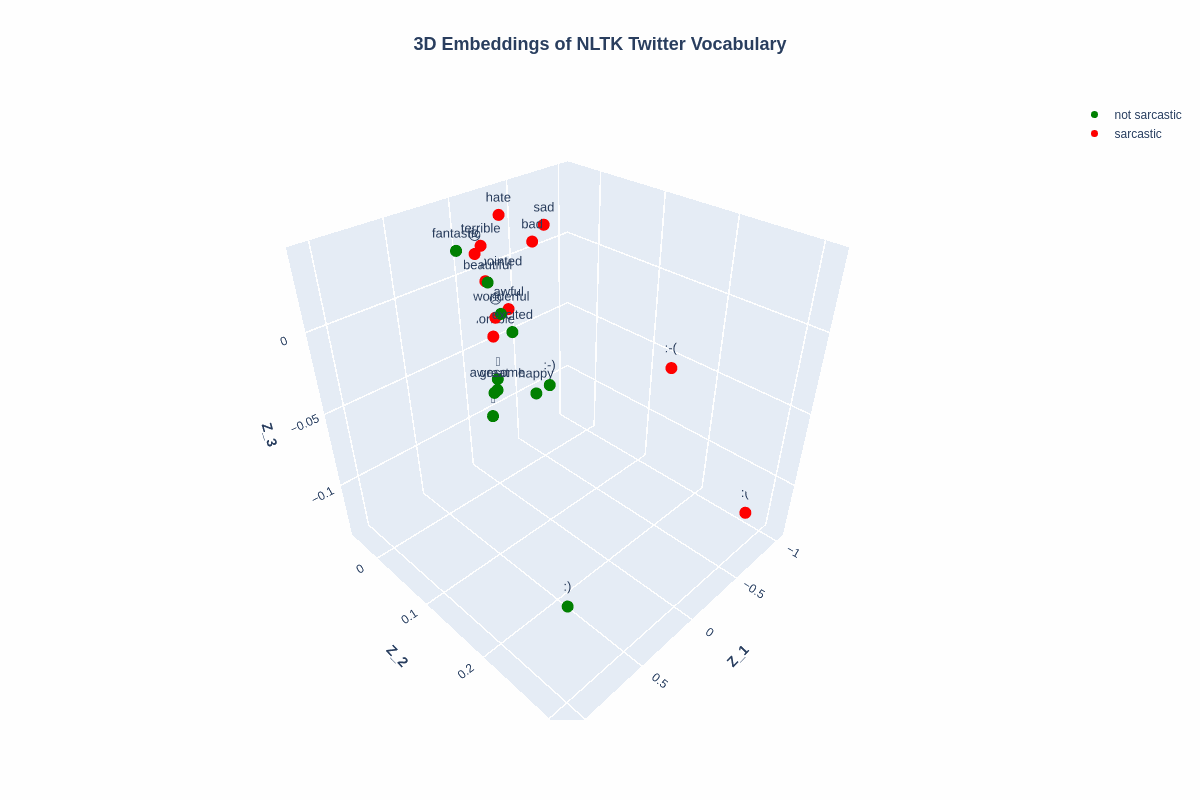

In [103]:
# Generate a GIF of the 3D word embeddings
directory_images = "/content/drive/MyDrive/images/text_classification"
directory_tc = os.path.join(directory_images, "lstm_twitter")
os.makedirs(directory_tc, exist_ok=True)
gif_file = os.path.join(directory_tc, "embedding_3d.gif")

create_gif(gif_file, fig, fps=0.5)
embed.embed_file(gif_file)

**With Matplotlib (for GitHub)**

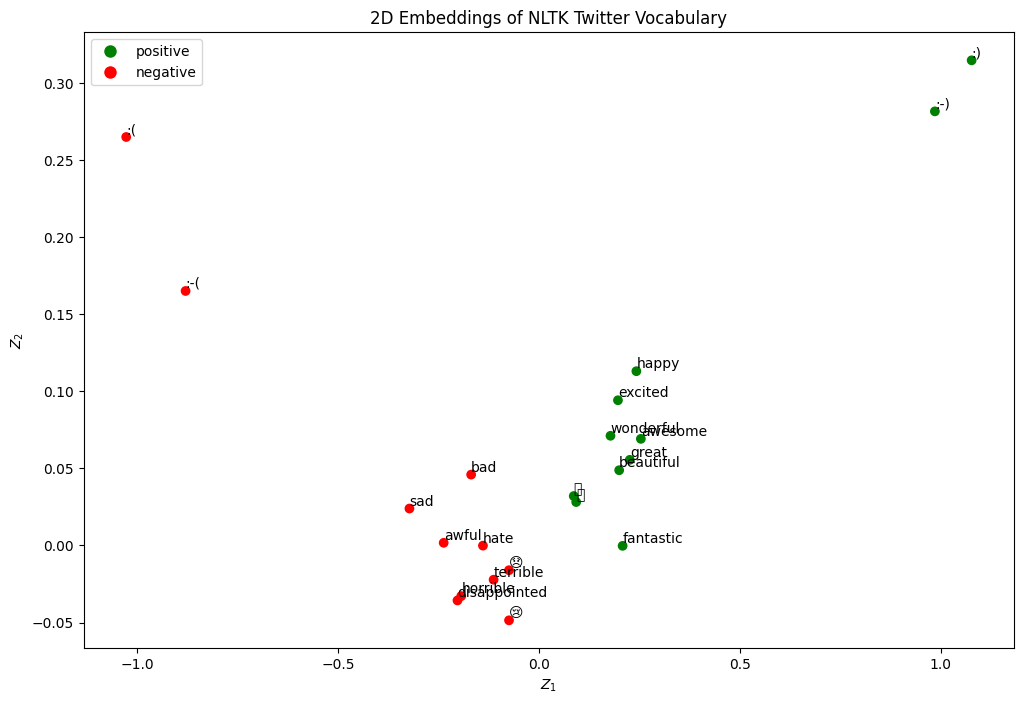

In [133]:
plt.figure(figsize=(12, 8))
plt.scatter(words_2d[:, 0], words_2d[:, 1], c=colors)
for i, word in enumerate(words):
    plt.annotate(word, xy=(words_2d[i, 0], words_2d[i, 1]), ha="left", va="bottom")

legend_handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10, label=label)
                  for color, label in zip(["green", "red"], ["positive", "negative"])]
plt.legend(handles=legend_handles, loc="best")

plt.xlabel("$Z_1$")
plt.ylabel("$Z_2$")
plt.title("2D Embeddings of NLTK Twitter Vocabulary")
plt.show()

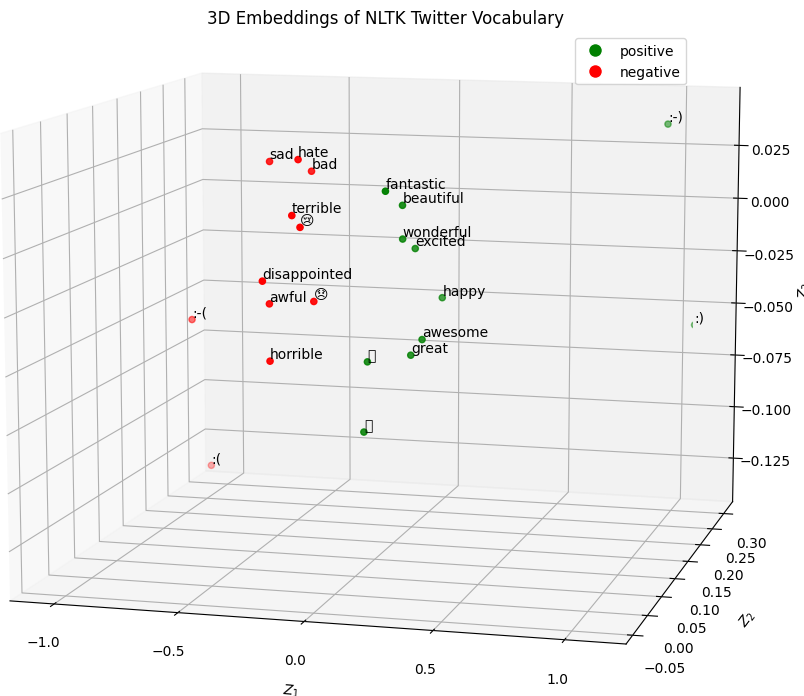

In [139]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(words_3d[:, 0], words_3d[:, 1], words_3d[:, 2], c=colors)

for i, word in enumerate(words):
    ax.text(words_3d[i, 0], words_3d[i, 1], words_3d[i, 2], word, ha="left", va="bottom")

legend_handles = [plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10, label=label)
                  for color, label in zip(["green", "red"], ["positive", "negative"])]
plt.legend(handles=legend_handles, loc="best")

ax.view_init(elev=10, azim=285)
ax.set_box_aspect(None, zoom=1.5)

ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.set_zlabel("$Z_3$")
plt.title("3D Embeddings of NLTK Twitter Vocabulary")
plt.show()

Thanks to the utilization of **PCA**, we are now able to visualize the trained weights of the embedding layer both in 2D and 3D. The vector representation of each word in the vocabulary, previously of dimension 128, has been reduced and projected into lower-dimensional space. This technique enables us to gain clearer insights into the word distribution. By observing the arrangement of words in the vector space, aided by Plotly's Zoom and Box Select tools, we can infer successful model training. Common words in positive tweets are cohesively grouped, as are words associated with negative tweets, suggesting a robust capture of semantic relationships. Additionally, there is a distinct separation between these two groups of words in the vector space, indicating the model's strong discriminative ability.